#コロナ禍での行動変容の効果をLLMで再現できるか調べる\n
##実装する機能
・プロンプト入力
・プロンプト回答
・集計
・表作成

In [45]:
#import libraries
import os
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import ast
import json
from collections import Counter


client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
    )
pd.set_option('display.max_colwidth', None)

In [46]:
def generate_completion(role, prompt,questionaire):
    response = client.chat.completions.create(
        model="gpt-4o",
        #model="gpt-3.5-turbo-1106",
        messages=[
            {"role": "system", "content": role},
            {"role": "user", "content": f"{prompt},\n{questionaire}"}
        ],
        temperature=0.7,
        max_tokens=1000,
        )
    return response

In [47]:
#make role
# Drinking frequency list
drinking_frequency_list = [
    "Never drink",
    "I used to drink, but I quit",
    "Few times per month",
    "1-2 times per week",
    "3-6 times per week",
    "Every day"
]

# Smoking frequency list
smoking_frequency_list = [
    "Every day",
    "Sometimes",
    "Used to smoke but do not now",
    "Never smoked"
]

# Sex list
sex_list = [
    "Male",
    "Female"
]

# Marital status list
marital_status_list = [
    "Married",
    "Not married"
]

# Education level list
education_list = [
    "Yes",
    "No"
]

# Children status list
children_status_list = [
    "Yes",
    "No"
]

# Work status list
work_status_list = [
    "Regular employee",
    "Non-regular employee",
    "Self-employed and others",
    "Not working"
]

# Household annual income list
household_income_list = [
    "Less than 2,000K JPY",
    "2,000-3,999K JPY",
    "4,000-5,999K JPY",
    "6,000-7,999K JPY",
    "8,000-9,999K JPY",
    "10,000-11,999K JPY",
    "12,000-14,999K JPY",
    "15,000-19,999K JPY",
    "More than 20,000K JPY",
    "Do not know"
]

# Age list
age_list = [
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-64"
]

age="20-29" #random.choice(age_list)
sex="male" #random.choice(sex_list)


#role = f"Act as a person with the following attributes. {random.choice(age_list)} years old, {random.choice(sex_list)}."
role =f"You are a person who is {age} years old,{sex}"
#make prompt
prompt="Understanding Your Attitude Towards Covid-19 Prevention\n\
We invite you to participate in this questionnaire to help us gain insights into your attitudes and behaviors regarding Covid-19 prevention. Your responses will be invaluable in shaping effective public health strategies.\n\
Instructions:\n\
・Carefully consider each question independently.\n\
・Select the option that best reflects your current situation and personal views.\n\
・Answer each question based solely on your own experiences and beliefs.\n\
Answer Format Example:\n\
Go shopping everyday\n\
['1.Very true']\n\
Thank you for your participation."

#make options
options_list=["1.Very true","2.True","3.Neither","4.Not true","5.Not at all"]
questions_list=["Avoid a poorly-ventilated closed space",
"Avoid large gatherings",
"Avoid conversations or shouting in close proximity",
"Avoid places where items 1-3 above overlap",
"Do not go to dinner with friends",
"Do not go to mass gatherings",
"Participate in virtual events using online tools",
"Undertake frequent handwashing",
"Undertake cough etiquette (use handkerchiefs or sleeves instead of hands)",
"Disinfect things around",
"Avoid going out when you have a cold",
"Avoid going to clinic even when having a cold symptom",
"Prepare consultation and transportation methods for when you feel ill",
"Always wear a surgical-style mask when going out",
"Stockpile surgical-style masks",
"Stockpile food, toilet paper, tissue paper, etc.",
"Avoid contact with younger people",
"Avoid contact with older people",
"Get sufficient rest and sleep",
"Eat a nutritious diet",
"Do exercise such as jogging or exercise using DVD"]

#make questionaire
questionaire="Have you ever conducted anything to prevent novel coronavirus infections or outbreaks?\n\n"
for i in range(len(questions_list)):
    questionaire+=f"{questions_list[i]}\n{options_list}\n\n"

def get_answer(content) -> dict[str:str]:
    pattern = re.compile(r"\['(.*?)'\]")
    answers = pattern.findall(content)
    answers_dict = dict(zip(questions_list,answers))
    return answers_dict
"""
response = generate_completion(role,prompt,questionaire)
content=response.choices[0].message.content
answers=get_answer(content)
print(type(answers))
print(answers)
"""

'\nresponse = generate_completion(role,prompt,questionaire)\ncontent=response.choices[0].message.content\nanswers=get_answer(content)\nprint(type(answers))\nprint(answers)\n'

In [48]:
def generate_data(count)->pd.DataFrame:
    global age_list, sex_list, prompt, questionaire
    data = []
    #generate completion
    for i in range(count):
        age=random.choice(age_list)
        sex=random.choice(sex_list)
        drink=random.choice(drinking_frequency_list)
        smoke=random.choice(smoking_frequency_list)
        marital=random.choice(marital_status_list)
        education=random.choice(education_list)
        children=random.choice(children_status_list)
        work=random.choice(work_status_list)
        income=random.choice(household_income_list)
        #role = f"Act as a person with the following attributes. {random.choice(age_list)} years old, {random.choice(sex_list)}."
        role =f"You are {age} years old,{sex},{drink},{smoke},{marital},{education},{children} and {work}. Household annual income is {income}.You live in Japan.Today is 2020/03/26"
        response = generate_completion(role, prompt,questionaire)
        content = response.choices[0].message.content
        answers = get_answer(content)
        u_40 = 0 if age in ["20-29","30-39"] else 1
        new_data = {"age":age,"u_40":u_40,"sex":sex,"content":content}
        new_data.update(answers)
        data.append(new_data)

    df_data = pd.DataFrame(data)
    return df_data

In [49]:
import pandas as pd
# aggregate data
def aggregate_data(df_data):
    global questions_list, options_list
    #aggregate data
    data_aggregate =[]
    for question in questions_list:
        for option in options_list:
            count = df_data[question].str.contains(option).sum()
            data_aggregate.append({"question":question,"option":option,"count":count})

    df_aggregate = pd.DataFrame(data_aggregate)
    # Pivot the DataFrame
    df_aggregate_pivot = df_aggregate.pivot(index='question', columns='option', values='count')

    # Fill NaN with 0 (if any)
    df_aggregate_pivot = df_aggregate_pivot.fillna(0)
    return df_aggregate_pivot



In [50]:
def separate_dataframes(df_data, filter_list, filter_column):
    """
    Separate the DataFrame based on the unique values in the specified column.

    Parameters:
    df_data (pd.DataFrame): The input DataFrame.
    filter_list (list): The list of unique values to filter by.
    filter_column (str): The column to filter on.

    Returns:
    dict: A dictionary of DataFrames filtered by the specified column values.
    """
    df_data_dict = {}
    for value in filter_list:
        df_data_dict[f'df_data_{value}'] = df_data[df_data[filter_column] == value]
    return df_data_dict

In [51]:
import pandas as pd

def aggregate_dataframes(df_data_dict):

    # Create an iterator from the dictionary items
    dict_iterator = iter(df_data_dict.items())

    # Retrieve values one by one
    try:
        key,value = next(dict_iterator)
        df_aggregate_1 = aggregate_data(value)

        key,value = next(dict_iterator)
        df_aggregate_2 = aggregate_data(value)

        # Continue calling next(dict_iterator) as needed
    except StopIteration:
        print("No more items in the dictionary.")
    return df_aggregate_1,df_aggregate_2

def calculate_ratio(df_aggregate,attribute):
    df_aggregate[f"Ratio of true:{attribute}"] = round(((df_aggregate["1.Very true"] + df_aggregate["2.True"])*100/df_aggregate.sum(axis=1)),2)
    return df_aggregate[f"Ratio of true:{attribute}"]

def TablePlot(df,w,h):
    fig, ax = plt.subplots(figsize=(w,h))
    ax.axis('off')
    ax.table(
        df.values,
        colLabels = df.columns,
        rowLabels=df.index,
        loc = 'center',
        bbox=[0,0,1,1]
    )
    plt.show()


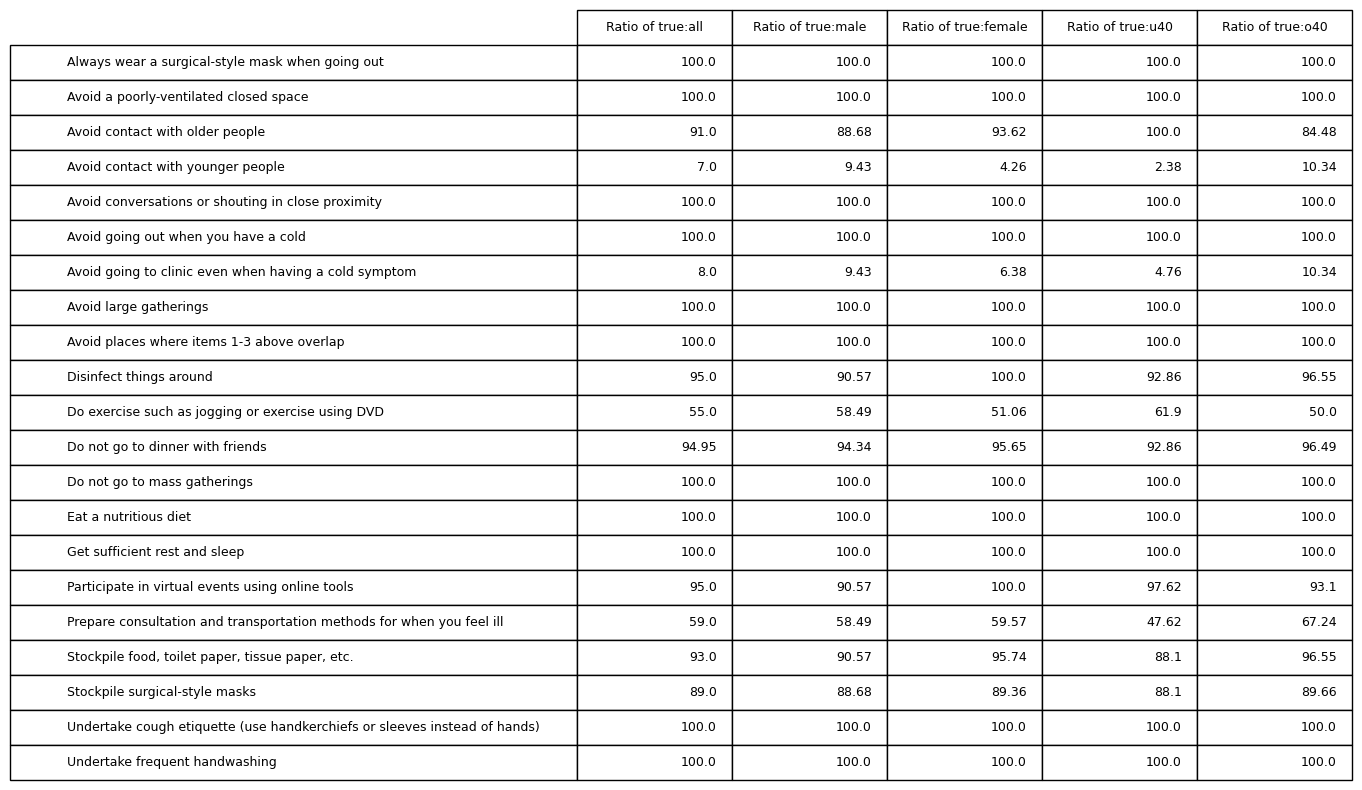

In [52]:
number_of_sample = 100
df_data = generate_data(number_of_sample)

df_data_dict_sex = separate_dataframes(df_data,sex_list,"sex")
df_data_dict_age = separate_dataframes(df_data,[0,1],"u_40")

df_aggregate = aggregate_data(df_data)

df_male_aggregate,df_female_aggregate = aggregate_dataframes(df_data_dict_sex)
df_u40_aggregate,df_o40_aggregate = aggregate_dataframes(df_data_dict_age)

dataframes_to_process = {
    "all":df_aggregate,
    "male":df_male_aggregate,
    "female":df_female_aggregate,
    "u40":df_u40_aggregate,
    "o40":df_o40_aggregate
}

# Calculate ratios for each DataFrame
ratios = [calculate_ratio(df,key) for key,df in dataframes_to_process.items()]

# Concatenate the resulting DataFrames
df_ratio_unif = pd.concat(ratios, axis=1)

df_data.to_csv("./0528_file/df_data.csv")
df_ratio_unif.to_csv("./0528_file/df_ratio_unif.csv")

TablePlot(df_ratio_unif,10,10)

In [91]:
#print(df_data_dict_sex)
dict_iterator = iter(df_data_dict_sex.items())


# Retrieve values one by one
try:
    key, value = next(dict_iterator)
    print(f"Key: {key}, Value:\n{value}\n")

    key, value = next(dict_iterator)
    print(f"Key: {key}, Value:\n{value}\n")

    # Continue calling next(dict_iterator) as needed
except StopIteration:
    print("No more items in the dictionary.")


Key: df_data_male, Value:
      age  u_40   sex   
0   40-49     1  male  \
1   50-59     1  male   
2   40-49     1  male   
4   20-29     0  male   
6   40-49     1  male   
8   30-39     0  male   
9   20-29     0  male   
10  30-39     0  male   
14  50-59     1  male   
16  50-59     1  male   
17  30-39     0  male   
19  30-39     0  male   
22  40-49     1  male   
23  20-29     0  male   
24  30-39     0  male   
26  50-59     1  male   
29  50-59     1  male   
30  60-64     1  male   
37  40-49     1  male   
38  50-59     1  male   
40  30-39     0  male   
41  20-29     0  male   
42  60-64     1  male   
43  20-29     0  male   
45  40-49     1  male   
49  30-39     0  male   

                                                                                                                                                                                                                                                                                                          